<a href="https://colab.research.google.com/github/pablojrios/fluence_maps/blob/master/tf2_transfer_learning_gamma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with a pretrained ConvNet

In [1]:
def isGoogleColab():
    # 'ipykernel.zmqshell' runs in our server
    # 'google.colab._shell' runs in Google Colab
    return get_ipython().__class__.__module__ == 'google.colab._shell'

#import sys
#import IPython

#if 'ipykernel' in sys.modules:
#    ip = sys.modules['ipykernel']
#    ip_version = ip.version_info
#    ip_client = ip.write_connection_file.__module__.split('.')[0]

#ip_version, ip_client

#ip_version = IPython.utils.sysinfo.get_sys_info()['ipython_version']
#ip_version

#if 'IPython' in sys.modules:
#    ip = sys.modules['IPython']
#    ip_version = ip.version_info
#    print(ip_version)

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from random import shuffle, randrange
import random
import tensorflow_addons as tfa
from enum import Enum

In [3]:
import tensorflow as tf
print('Tensorflow version = {}, addons version = {}'.format(tf.__version__, tfa.__version__))
print('Executing eagerly = {}'.format(tf.executing_eagerly()))
keras = tf.keras

import cv2 # to perform data augmentation
print('OpenCV version = {}'.format(cv2.__version__))

datetime.now().strftime("%d/%m/%Y %H:%M:%S")

Tensorflow version = 2.2.0, addons version = 0.10.0
Executing eagerly = True
OpenCV version = 3.4.2


'06/02/2021 21:26:01'

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

if isGoogleColab():
    %cd '/content'
    if os.path.exists('fluence_maps'):
      !rm -fr fluence_maps

    ## Install required dependencies
    !pip install -q pydicom
    ## to support ResNet18 and ResNet34
    !pip install image-classifiers
    ## https://github.com/tensorflow/addons/issues/2251
    !pip install -U tensorflow-addons

    GIT_USERNAME = "pablojrios"
    GIT_TOKEN = "1d88a0b85d2b00a03796e4d8b7e5f7b249b12f9b"
    !git clone -s https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/fluence_maps.git

    from google.colab import drive
    drive.mount('/content/drive')
    
    %cd -q '/content/fluence_maps'
    
    ARG_DATASET_DIR='/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata'

In [5]:
# To support ResNet18 and ResNet34 for tensorflow.keras
from classification_models.tfkeras import Classifiers
from util.preprocess import rescale_0_to_1

In [6]:
class CNN(Enum):
        vgg16 = 1
        resnet18 = 2
        resnet34 = 3
        mobilenetV2 = 4

In [7]:
# ===============================================DEFINE YOUR ARGUMENTS=================================================
if not isGoogleColab():
    ARG_DATASET_DIR='/hdd/data/radioterapia/ciolaplata'
# folder under ARG_DATASET_DIR path.
ARG_RANDOM_SEED = 23456
# ARG_TFDATASET_FOLDER=f'tfds.2018-2019.localnorm.DS10%.{ARG_RANDOM_SEED}.fold0'
ARG_TFDATASET_FOLDER=f'tfds.2019-2017.localnorm.DS10%.{ARG_RANDOM_SEED}.fold1'
# if False only training and validation partition are created.
ARG_TEST_PARTITION=False
ARG_NETWORK=CNN.mobilenetV2
ARG_RESNET_USE_BN=True

# number of continuous epochs without improvement on validation
ARG_EPOCHS_WO_IMPROVEMENT=30 # 20 for 2019 only, 10 for 2019+2018, 30 for 2019+2018 for MobileNetV2
initial_epochs = 10 # 10 for 2019 only, 5 for 2019+2018
# maximum fine-tuning epochs
ARG_MAX_FINE_TUNING_EPOCHS=200
# 0: use custom LR, 1: use ReduceLROnPlateau
ARG_LR_SCHEDULE=1
ARG_LR_PATIENCE=15 # only applies if ARG_LR_SCHEDULE is 1. Equals to 10 except for MobileNetV2 that requires 15+
ARG_MIN_DELTA_MAE=0.01

ARG_DATA_AUGMENTATION=False
# perform data augmentation of images with a gamma value lower than gamma_augment
ARG_GAMMA_AUGMENT=97.0
# set this value based on the ARG_OVERSAMPLING_FACTOR value in tf2_oversampling_dicom_files.py
# 1.0 means transform each and every image, with a lower value than 1.0 means that training will include unmodified (not transformed)
# images.
ARG_AUGMENT_PROBABILITY=0.75 # con 0.85 para el dataset tfds.2019.localnorm.ovs95x8.0 no transformo 93*(1+8)*0.15=125 imágenes  
add_regularizers=False
## Fine-tune from this layer onwards
# fine_tune_at = 281 # InceptionV3, fine-tuning
# fine_tune_at = 102 # InceptionV3, not so fine-tuning
# fine_tune_at = 74 # resnet34 stage3
# fine_tune_at = 129 # resnet34 stage4
if ARG_NETWORK == CNN.vgg16:
    fine_tune_at = 11 # VGG16
elif ARG_NETWORK == CNN.resnet18:
    fine_tune_at = 46 # resnet18 stage3
elif ARG_NETWORK == CNN.resnet34:
    fine_tune_at = 73 # resnet34 stage3
else:
    fine_tune_at = 117 # MobileNetV2 block_12_add para atrás
ARG_TRANSFORM_GAMMA=False


## Data preprocessing

### Data download

In [8]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

tf.random.set_seed(ARG_RANDOM_SEED)

In [9]:
def _tfrecord_dataset_type_from_folder(folder, dataset_type, ext='.tfrecords'):
    tfrecords = [os.path.join(folder, n)
                 for n in os.listdir(folder) if n.startswith(dataset_type) and n.endswith(ext)]
    return tf.data.TFRecordDataset(tfrecords)

tfdataset_dir = os.path.join(ARG_DATASET_DIR, ARG_TFDATASET_FOLDER)
# type(raw_train) is tensorflow.python.data.ops.readers.TFRecordDatasetV2
raw_train = _tfrecord_dataset_type_from_folder(tfdataset_dir, 'train')
raw_validation = _tfrecord_dataset_type_from_folder(tfdataset_dir, 'validation')
if ARG_TEST_PARTITION:
    raw_test = _tfrecord_dataset_type_from_folder(tfdataset_dir, 'test')

The resulting `tf.data.Dataset` objects contain `(image, label)` pairs where the images have variable shape and 3 channels, and the label is a scalar.

In [10]:
print(raw_train)
print(raw_validation)
if ARG_TEST_PARTITION:
    print(raw_test)

<TFRecordDatasetV2 shapes: (), types: tf.string>
<TFRecordDatasetV2 shapes: (), types: tf.string>


In [11]:
print(f'Number of images in training part = {sum(1 for _ in raw_train)}.')
print(f'Number of images in validation part = {sum(1 for _ in raw_validation)}.')

Number of images in training part = 3414.
Number of images in validation part = 854.


In [12]:
def _parse_image_function(example_proto, img_size, normalization_fn, data_augmentation=False, augment_probability=1.0, transform_gamma=False):
    # Create a dictionary describing the features.
    image_feature_description = {"image/filename": tf.io.FixedLenFeature((), tf.string),
                "image/encoded": tf.io.FixedLenFeature((), tf.string),
                "image/format": tf.io.FixedLenFeature((), tf.string),
                "image/gamma_index": tf.io.FixedLenFeature((), tf.float32),
                "image/height": tf.io.FixedLenFeature((), tf.int64),
                "image/width": tf.io.FixedLenFeature((), tf.int64)}
    
    def image_augment(image):
        radian = ((np.random.random()-.50)*10 / 360) * np.pi
        # tfa.image.transform_ops.rotate(image, radian) is an alias
        image = tfa.image.rotate(image, radian)
        # image = tf.image.random_flip_left_right(image)
        image = random_translation(image)
        return image

    # Now, globally set everything to run eagerly
    # The following doesn't set to eager mode:
    # UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set,
    # this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
    # tf.config.run_functions_eagerly(True)

    # Executing eagerly = False here!
    # numpy is only supported in eager mode. If you are in graph mode, it will not be supported.
    # In eager execution the shape is always fully-known.
    # print('Executing eagerly = {}'.format(tf.executing_eagerly()))

    # Parse the input tf.Example proto using the dictionary above.
    parsed = tf.io.parse_single_example(example_proto, image_feature_description)
    
    image = tf.image.decode_jpeg(parsed["image/encoded"], channels=3)
    # print(type(image), image.shape, image.dtype) # <class 'tensorflow.python.framework.ops.Tensor'> (None, None, 3) <dtype: 'uint8'>

    gamma = tf.cast(
        parsed["image/gamma_index"],
        tf.float32)
    # print(type(gamma), gamma.shape, gamma.dtype) # <class 'tensorflow.python.framework.ops.Tensor'> () <dtype: 'float32'>

    image = normalization_fn(image)

    image = tf.image.resize(image, (img_size, img_size))
    print(type(image), image.shape, image.dtype)

    if data_augmentation and augment_probability >= random.uniform(0, 1):
        gamma_augment = tf.constant(ARG_GAMMA_AUGMENT)
        image = tf.cond(tf.math.less(gamma, gamma_augment)
                        , lambda: image_augment(image)
                        , lambda: image)

    # normalizo antes de transformar
    # image = normalization_fn(image)
    
    #label is a tensor of an array of single tf.int64 arrays.
    #label = tf.cast(
    #    tf.reshape(parsed["image/class/label"], [-1]),
    #    tf.int64)

    # assert tf.executing_eagerly() FAILS
    # parsed["image/filename"] is a Tensor and not an EagerTensor because we are in a map function,
    # because in 2.0, code inside Datasets maps is turned into a subgraph for speed, just as it was in 1.x eager
    # execution. You generally want to avoid Python inside your data pipeline.
    # So, if I invoke parsed["image/filename"].numpy().decode('utf-8') to get the filename string the error
    # "AttributeError: 'Tensor' object has no attribute 'numpy'" is thrown, hence I return a tensor.
    filename = parsed["image/filename"]

    if transform_gamma:
        gamma = 60.0 - (105 - gamma)
                    
    return image, gamma, filename

In [13]:
IMG_SIZE = 256 # All images will be resized to 256x256
if ARG_NETWORK == CNN.mobilenetV2: IMG_SIZE = 224

normalization_fn = rescale_0_to_1 # rescale_min_1_to_1
# normalization_fn = tf.image.per_image_standardization # loss y mae en validación reportan números muy grandes,
# no así en training.

In [14]:
num_workers = 8

# assert tf.executing_eagerly()
if ARG_DATA_AUGMENTATION:
    print("Training with image augmentation.")
    
train = raw_train.map(lambda e: _parse_image_function(e, IMG_SIZE, normalization_fn, ARG_DATA_AUGMENTATION, ARG_AUGMENT_PROBABILITY,
                                                      transform_gamma=ARG_TRANSFORM_GAMMA),
                      num_parallel_calls=num_workers)
validation = raw_validation.map(lambda e: _parse_image_function(e, IMG_SIZE, normalization_fn, transform_gamma=ARG_TRANSFORM_GAMMA),
                                num_parallel_calls=num_workers)
if ARG_TEST_PARTITION:
    test = raw_test.map(lambda e: _parse_image_function(e, IMG_SIZE, normalization_fn),
                        num_parallel_calls=num_workers)

<class 'tensorflow.python.framework.ops.Tensor'> (224, 224, 3) <dtype: 'float32'>
<class 'tensorflow.python.framework.ops.Tensor'> (224, 224, 3) <dtype: 'float32'>


In [15]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = 2 * BATCH_SIZE

In [16]:
print('Executing eagerly = {}'.format(tf.executing_eagerly()))

# <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.int64)>
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
print(train_batches)
validation_batches = validation.batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
print(validation_batches)
# <BatchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.int64)>
if ARG_TEST_PARTITION:
    test_batches = test.batch(BATCH_SIZE)
    print(test_batches)

Executing eagerly = True
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>


Inspect a batch of data:

In [17]:
for image_batch, label_batch, filename_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape, filename_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32]), TensorShape([32]))

gamma=98.07, filename=/hdd/data/radioterapia/ciolaplata/2017/1.3.6.1.4.1.9590.100.1.2.176117793912613699912684348602914932416.dcm
image shape = (224, 224, 3)


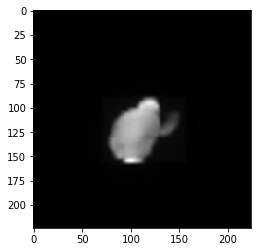

In [18]:
# display 2nd image in the batch
gamma_value = label_batch[8].numpy()
filename = filename_batch[8].numpy().decode('utf-8')
print(f'gamma={gamma_value:2.2f}, filename={filename}')
# if pixel values are float they have to be in [0, 1] range, if they are integer they have to be in the [0, 255] range,
# else pixel values are truncated.
im = image_batch[8].numpy()
plt.imshow(im)
print("image shape = {}".format(im.shape))

In [19]:
im[:,:,0].max()

0.99391645

## Create the base model from the pre-trained convnets

In [20]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

if ARG_NETWORK==CNN.resnet18:
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

elif ARG_NETWORK==CNN.resnet34:
    ResNet34, preprocess_input = Classifiers.get('resnet34')
    base_model = ResNet34(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

elif ARG_NETWORK== CNN.mobilenetV2:
    ## Create the base model from the pre-trained model MobileNet V2
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   # alpha=1.4,
                                                   weights='imagenet',
                                                   include_top=False)

else:
    base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                                   weights='imagenet',
                                                   include_top=False)

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. See what it does to the example batch of images:

In [21]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [22]:
if not (ARG_NETWORK == CNN.resnet18 or ARG_NETWORK == CNN.resnet34):
    base_model.trainable = False
else:
    # resnet
    for layer in base_model.layers:
            if layer.__class__.__name__ != "BatchNormalization":
                layer.trainable = False
            else:
                print(f"{layer.name} ({layer.__class__.__name__})")

In [23]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [24]:
from add_regularization import add_regularization
# adds a tf.keras.regularizers.l2(0.0001)
#"kernel_regularizer":{
#                        "class_name": "L1L2",
#                        "config": {
#                            "l1": 0,
#                            "l2": 0.0001
#                        }
#                     }
if add_regularizers:
    base_model = add_regularization(base_model)

for layer in base_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
            if getattr(layer, attr) is None:
                print('layer {} has no regularizer.'.format(layer.name))
            else:
                print('layer {} has a regularizer {}.'.format(layer.name, getattr(layer, attr)))


layer Conv1 has no regularizer.
layer expanded_conv_depthwise has no regularizer.
layer expanded_conv_project has no regularizer.
layer block_1_expand has no regularizer.
layer block_1_depthwise has no regularizer.
layer block_1_project has no regularizer.
layer block_2_expand has no regularizer.
layer block_2_depthwise has no regularizer.
layer block_2_project has no regularizer.
layer block_3_expand has no regularizer.
layer block_3_depthwise has no regularizer.
layer block_3_project has no regularizer.
layer block_4_expand has no regularizer.
layer block_4_depthwise has no regularizer.
layer block_4_project has no regularizer.
layer block_5_expand has no regularizer.
layer block_5_depthwise has no regularizer.
layer block_5_project has no regularizer.
layer block_6_expand has no regularizer.
layer block_6_depthwise has no regularizer.
layer block_6_project has no regularizer.
layer block_7_expand has no regularizer.
layer block_7_depthwise has no regularizer.
layer block_7_project h

In [25]:
# display the weights of some layers
l = 1
for layer in base_model.layers:
    # print('layer {:3d}, name: {}'.format(l, layer.name))
    if layer.name == "expanded_conv_project":
        weights = layer.get_weights()
        print(layer.get_config(), weights, weights[0].shape)
    l += 1

{'name': 'expanded_conv_project', 'trainable': False, 'dtype': 'float32', 'filters': 16, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[[[-1.29452934e-02, -3.69312555e-01,  5.61136663e-01,
          -7.24593937e-01, -1.05702937e-01, -5.26386082e-01,
           1.42754480e-01, -1.74769133e-01, -1.56823814e-01,
          -2.30223924e-01,  4.38534804e-02,  1.36561438e-01,
          -2.13272557e-01, -3.72024477e-02, -1.12825830e-03,
           8.76550749e-02],
         [-8.75060409e-02, -2.65158892e-01, -1.80831134e-01,
          -1.19943023e-01,  9.03041437e-02,  1.93148971e-01,
          -1.68531

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Stack the feature extractor, and these two layers using a `tf.keras.Sequential` model for network architectures other than ResNet:

In [27]:
num_activation_filders = 512
if ARG_NETWORK == CNN.mobilenetV2:
    num_activation_filders = 1280

if not (ARG_NETWORK == CNN.resnet18 or ARG_NETWORK == CNN.resnet34):
    # Pablo March 10: add sigmoid
    # WARNING: adding the activation function causes loss to keep close to 0.5 and does not decrease.
    # prediction_layer = keras.layers.Dense(1, activation='sigmoid') # para obtener probabilidades y no logits

    # https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes
    # https://stackoverflow.com/questions/58627411/how-to-use-inception-network-for-regression

    # let's add a fully-connected layer
    fc1 = keras.layers.Dense(num_activation_filders, activation='relu')
    #fc2 = keras.layers.Dense(num_activation_filders, activation='relu')
    #dropout = keras.layers.Dropout(rate=0.05) # no funciona
    # and a linear output layer (regression)

    bn = keras.layers.BatchNormalization() # same as ResNet18 but with VGG16 is worst.

    prediction_layer = keras.layers.Dense(1, activation='linear')
    # and a logistic layer -- let's say we have 200 classes (classification)
    # prediction_layer = Dense(200, activation='softmax')(x)

    # Up to March 27, 2020
    # prediction_layer = keras.layers.Dense(1)
    prediction_batch = prediction_layer(feature_batch_average)
    print(prediction_batch.shape)

    # Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:
    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      fc1,
      #bn,
      #dropout,
      #fc2,
      prediction_layer
    ])
    
else:
    avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    out = tf.keras.layers.Dense(num_activation_filders, activation="relu")(avg) # CHANGE to use avg pool only or avg pool + max pool
    if ARG_RESNET_USE_BN:
        # no observé mejoras en 2017 agregando esta bn layer, pero sí observé mejoras en 4 de 5 folds de cross validation
        # en 2019+2017
        out = tf.keras.layers.BatchNormalization()(out)
    prediction_layer = tf.keras.layers.Dense(1, activation='linear')(out)
    model = keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

(32, 1)


### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [28]:
base_learning_rate = 0.001
# mse = square(y_true - y_pred)
# mae = loss = abs(y_true - y_pred)
# mape = 100 * abs(y_true - y_pred) / y_true
# mae y mape son similares, no iguales, por eso tomo MAE que es el promedio de la diferencia absoluta entre el
# gamma real y el gamma predicho
# optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate, momentum=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['mse'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1280)              1639680   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 3,898,945
Trainable params: 1,640,961
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the model

In [30]:
num_train = sum(1 for _ in raw_train)
num_val = sum(1 for _ in raw_validation)
print(f'Number of images in train partition: {num_train}, in validation: {num_val}.')
if ARG_TEST_PARTITION:
    num_test = sum(1 for _ in raw_test)
    print(f'Number of images in test partiton: {num_test}.')

Number of images in train partition: 3414, in validation: 854.


In [31]:
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps=20

# projects out just the first two components.
tmp_validation_batches = validation_batches.map(lambda image, gamma, filename: (image, gamma))
print(tmp_validation_batches)

loss0 = mse0 = 0
loss0, mse0 = model.evaluate(tmp_validation_batches, steps = validation_steps)

<MapDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.float32)>
20/20 [==============================] - 1s 30ms/step - loss: 95.8476 - mse: 9211.6113


In [32]:
print("initial loss: {:.2f}".format(loss0))
print("initial mape: {:.2f}".format(mse0))

initial loss: 95.85
initial mape: 9211.61


In [33]:
# projects out just the first two components.
tmp_train_batches = train_batches.map(lambda image, gamma, filename: (image, gamma))
print(tmp_train_batches)

<MapDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.float32)>


In [34]:
# Implement callback function to stop training
class MyCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, wait_epochs):
        self.__wait_epochs = wait_epochs
        self.__latest_peak_mae = 50.0 # MobileNetV2 requires such a high value because it improves very slowly.
        self.__waited_epochs = 0
        self.__saved_model_file = None
        self.__saved_model = None
        
    def stopTraining(self, epoch, val_mae):
        stop_early = False
        best_mae = False
        # check for early stop
        if val_mae < self.__latest_peak_mae and abs(val_mae - self.__latest_peak_mae) > ARG_MIN_DELTA_MAE:
            best_mae = True
            self.__latest_peak_mae = val_mae
            print(f"\nNew peak val_mae reached: {val_mae:6.3}")

            t = time.time()
            dir = os.path.join(ARG_DATASET_DIR, "models")
            save_model_path = "{}/{}.{}.{}.h5".format(dir, int(t), ARG_NETWORK.name, ARG_RANDOM_SEED)
            print(save_model_path)
            # Either 'tf' or 'h5', indicating whether to save the model to Tensorflow SavedModel or HDF5. Defaults to 'tf' 
            # in TF 2.X, and 'h5' in TF 1.X.            
            model.save(save_model_path, save_format='h5')
            # borro el archivo del modelo anterior
            if self.__saved_model_file is not None:
                os.remove(self.__saved_model_file)
            self.__saved_model_file = save_model_path
            reloaded_model = tf.keras.models.load_model(save_model_path)
            self.__saved_model = reloaded_model

        if val_mae > self.__latest_peak_mae or not best_mae:
            # Si llevo N+ epochs sin mejora
            if self.__waited_epochs >= self.__wait_epochs:
                print("\nStopping early at epoch {0} with saved peak mae {1:10.8}"
                      .format(epoch + 1, self.__latest_peak_mae))
                stop_early = True
            
            self.__waited_epochs += 1
            
        else:
            self.__latest_peak_mae = val_mae
            # Reset waited epochs.
            print("waiting epochs reset.")
            self.reset_waited_epochs()
            
        return stop_early
        
    def on_epoch_end(self, epoch, logs={}):
        # print('\nTraining: epoch {} ends at {}'.format(epoch, datetime.now().strftime("%d/%m/%Y %H:%M:%S")))
        if self.stopTraining(epoch, logs.get('val_loss')):
            self.model.stop_training = True

    @property
    def saved_model_file(self):
        return self.__saved_model_file
    
    @property
    def saved_model(self):
        return self.__saved_model

    def reset_waited_epochs(self):
        self.__waited_epochs = 0;
    

# Instantiate a callback object
callbackObj = MyCallback(ARG_EPOCHS_WO_IMPROVEMENT)

In [35]:
history = model.fit(tmp_train_batches,
                    epochs=initial_epochs,
                    validation_data=tmp_validation_batches)

Epoch 1/10
107/107 [==============================] - 4s 39ms/step - loss: 12.2133 - mse: 429.3062 - val_loss: 5.9145 - val_mse: 60.7098
Epoch 2/10
107/107 [==============================] - 4s 38ms/step - loss: 5.1847 - mse: 45.4427 - val_loss: 5.2010 - val_mse: 47.4970
Epoch 3/10
107/107 [==============================] - 4s 38ms/step - loss: 4.2804 - mse: 32.6278 - val_loss: 4.5566 - val_mse: 36.9747
Epoch 4/10
107/107 [==============================] - 4s 38ms/step - loss: 3.8585 - mse: 26.8989 - val_loss: 4.2127 - val_mse: 32.5697
Epoch 5/10
107/107 [==============================] - 4s 38ms/step - loss: 3.5590 - mse: 23.4311 - val_loss: 4.0374 - val_mse: 30.4618
Epoch 6/10
107/107 [==============================] - 4s 38ms/step - loss: 3.7511 - mse: 24.6488 - val_loss: 3.9470 - val_mse: 30.0983
Epoch 7/10
107/107 [==============================] - 4s 37ms/step - loss: 3.2366 - mse: 20.0499 - val_loss: 4.8244 - val_mse: 37.9812
Epoch 8/10
107/107 [==============================] -

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

In [36]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [37]:
# Pablo Feb 25:
# Python never implicitly copies objects. When you set list2 = list1, you are making them refer to the same exact
# list object, so when you mutate it, all references to it keep referring to the object in its current state.
mse = history.history['mse'].copy()
val_mse = history.history['val_mse'].copy()

loss = history.history['loss'].copy()
val_loss = history.history['val_loss'].copy()

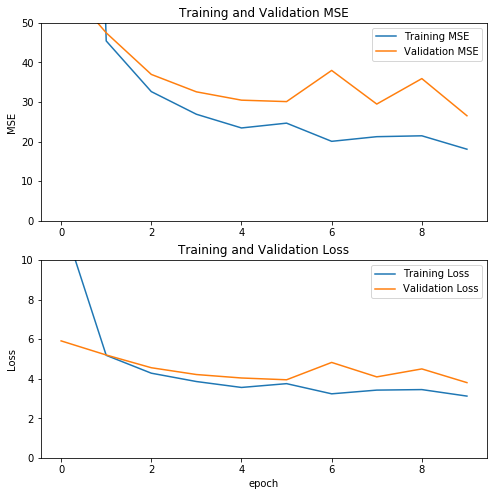

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mse, label='Training MSE')
plt.plot(val_mse, label='Validation MSE')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.ylim([0,50])
plt.title('Training and Validation MSE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,10])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of a VGG16 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole VGG16 model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [39]:
base_model.trainable = True

# Pablo Feb 25: con este loop me aseguro que las capas que en la próxima celda *NO* pongo como layer.trainable = False sean
# trainable.
l = 1
for layer in base_model.layers:
    print('layer {:3d}, name: {}'.format(l, layer.name))
    if layer.__class__.__name__ != "BatchNormalization":
        layer.trainable =  True
    l += 1

layer   1, name: input_1
layer   2, name: Conv1_pad
layer   3, name: Conv1
layer   4, name: bn_Conv1
layer   5, name: Conv1_relu
layer   6, name: expanded_conv_depthwise
layer   7, name: expanded_conv_depthwise_BN
layer   8, name: expanded_conv_depthwise_relu
layer   9, name: expanded_conv_project
layer  10, name: expanded_conv_project_BN
layer  11, name: block_1_expand
layer  12, name: block_1_expand_BN
layer  13, name: block_1_expand_relu
layer  14, name: block_1_pad
layer  15, name: block_1_depthwise
layer  16, name: block_1_depthwise_BN
layer  17, name: block_1_depthwise_relu
layer  18, name: block_1_project
layer  19, name: block_1_project_BN
layer  20, name: block_2_expand
layer  21, name: block_2_expand_BN
layer  22, name: block_2_expand_relu
layer  23, name: block_2_depthwise
layer  24, name: block_2_depthwise_BN
layer  25, name: block_2_depthwise_relu
layer  26, name: block_2_project
layer  27, name: block_2_project_BN
layer  28, name: block_2_add
layer  29, name: block_3_expa

In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

l = 1
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    if layer.__class__.__name__ != "BatchNormalization":
        print('layer {:3d}, name: {} set to not trainable.'.format(l, layer.name))
        layer.trainable = False
    l += 1

Number of layers in the base model:  155
layer   1, name: input_1 set to not trainable.
layer   2, name: Conv1_pad set to not trainable.
layer   3, name: Conv1 set to not trainable.
layer   5, name: Conv1_relu set to not trainable.
layer   6, name: expanded_conv_depthwise set to not trainable.
layer   8, name: expanded_conv_depthwise_relu set to not trainable.
layer   9, name: expanded_conv_project set to not trainable.
layer  11, name: block_1_expand set to not trainable.
layer  13, name: block_1_expand_relu set to not trainable.
layer  14, name: block_1_pad set to not trainable.
layer  15, name: block_1_depthwise set to not trainable.
layer  17, name: block_1_depthwise_relu set to not trainable.
layer  18, name: block_1_project set to not trainable.
layer  20, name: block_2_expand set to not trainable.
layer  22, name: block_2_expand_relu set to not trainable.
layer  23, name: block_2_depthwise set to not trainable.
layer  25, name: block_2_depthwise_relu set to not trainable.
layer 

### Compile the model

Compile the model using a much lower learning rate.

In [41]:
# This function keeps the learning rate at 0.001 for the first ten epochs
# and decreases it exponentially after that.
def lr_scheduler(epoch):
    lr = base_learning_rate
    #k = 0.15
    #if epoch >= 10 and epoch <= 40:
    #    lr = tf.math.exp(k * (10 - epoch)) * base_learning_rate
    #    print("\nlearning rate: %.8f"%(lr))
    if epoch >= 10 and epoch <= 30:
        lr = base_learning_rate/10
    elif epoch > 30 and epoch <= 60:
        lr = base_learning_rate/100
    elif epoch > 60:
        lr = base_learning_rate/500
    print("\nlearning rate: %.6f"%(lr))
    
    return lr
    
    
callbackLR = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [42]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=ARG_LR_PATIENCE, verbose=1, min_delta=0.01)

In [43]:
# optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10, momentum=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10, epsilon=1e-08, amsgrad=False)
model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer = optimizer,
              metrics=['mse'])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1280)              1639680   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 3,898,945
Trainable params: 3,338,433
Non-trainable params: 560,512
_________________________________________________________________


In [45]:
len(model.trainable_variables)

121

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [46]:
fine_tune_epochs = ARG_MAX_FINE_TUNING_EPOCHS
total_epochs =  (history.epoch[-1]+1) + fine_tune_epochs

# by default we use custom LR schedule
callbacks=[callbackObj, callbackLR]
if ARG_LR_SCHEDULE == 1:
    callbacks=[callbackObj, reduce_lr]
    
history_fine = model.fit(tmp_train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1]+1,
                         validation_data=tmp_validation_batches,
                         callbacks=callbacks)

Epoch 11/210
107/107 [==============================] - 9s 83ms/step - loss: 7.2271 - mse: 86.0966 - val_loss: 70.5667 - val_mse: 5024.9360 - lr: 1.0000e-04
Epoch 12/210
107/107 [==============================] - 8s 77ms/step - loss: 4.8435 - mse: 38.7666 - val_loss: 71.2069 - val_mse: 5123.5679 - lr: 1.0000e-04
Epoch 13/210
107/107 [==============================] - 8s 78ms/step - loss: 3.7489 - mse: 23.0918 - val_loss: 75.0788 - val_mse: 5686.8062 - lr: 1.0000e-04
Epoch 14/210
107/107 [==============================] - 8s 77ms/step - loss: 3.2827 - mse: 17.6148 - val_loss: 60.4418 - val_mse: 3696.4060 - lr: 1.0000e-04
Epoch 15/210
107/107 [==============================] - 8s 77ms/step - loss: 2.7677 - mse: 12.8981 - val_loss: 66.8652 - val_mse: 4519.5078 - lr: 1.0000e-04
Epoch 16/210
107/107 [==============================] - 8s 77ms/step - loss: 2.4565 - mse: 10.1866 - val_loss: 72.6631 - val_mse: 5322.4409 - lr: 1.0000e-04
Epoch 17/210
107/107 [==============================] - 8s

107/107 [==============================] - ETA: 0s - loss: 1.1440 - mse: 2.2662
New peak val_mae reached:   4.25
/hdd/data/radioterapia/ciolaplata/models/1612657946.mobilenetV2.23456.h5
waiting epochs reset.
107/107 [==============================] - 12s 111ms/step - loss: 1.1440 - mse: 2.2662 - val_loss: 4.2471 - val_mse: 40.7676 - lr: 1.0000e-04
Epoch 44/210
107/107 [==============================] - 8s 77ms/step - loss: 1.1387 - mse: 2.2630 - val_loss: 6.1382 - val_mse: 67.1583 - lr: 1.0000e-04
Epoch 45/210
107/107 [==============================] - 8s 77ms/step - loss: 1.0579 - mse: 2.0222 - val_loss: 5.3533 - val_mse: 49.9793 - lr: 1.0000e-04
Epoch 46/210
107/107 [==============================] - ETA: 0s - loss: 1.0558 - mse: 1.9668
New peak val_mae reached:   3.84
/hdd/data/radioterapia/ciolaplata/models/1612657975.mobilenetV2.23456.h5
waiting epochs reset.
107/107 [==============================] - 11s 106ms/step - loss: 1.0558 - mse: 1.9668 - val_loss: 3.8404 - val_mse: 29.786

107/107 [==============================] - 8s 77ms/step - loss: 0.4660 - mse: 0.3736 - val_loss: 2.2719 - val_mse: 11.6653 - lr: 2.0000e-05
Epoch 85/210
107/107 [==============================] - ETA: 0s - loss: 0.4845 - mse: 0.4203
New peak val_mae reached:   2.01
/hdd/data/radioterapia/ciolaplata/models/1612658332.mobilenetV2.23456.h5
waiting epochs reset.
107/107 [==============================] - 11s 107ms/step - loss: 0.4845 - mse: 0.4203 - val_loss: 2.0121 - val_mse: 10.0987 - lr: 2.0000e-05
Epoch 86/210
107/107 [==============================] - ETA: 0s - loss: 0.4762 - mse: 0.3944
New peak val_mae reached:    2.0
/hdd/data/radioterapia/ciolaplata/models/1612658344.mobilenetV2.23456.h5
waiting epochs reset.
107/107 [==============================] - 12s 108ms/step - loss: 0.4762 - mse: 0.3944 - val_loss: 1.9956 - val_mse: 9.9014 - lr: 2.0000e-05
Epoch 87/210
107/107 [==============================] - 8s 77ms/step - loss: 0.4880 - mse: 0.4007 - val_loss: 1.9952 - val_mse: 9.8369 

107/107 [==============================] - 8s 77ms/step - loss: 0.3207 - mse: 0.1846 - val_loss: 1.9901 - val_mse: 9.5183 - lr: 8.0000e-07
Epoch 132/210
107/107 [==============================] - 8s 77ms/step - loss: 0.3276 - mse: 0.1917 - val_loss: 1.9965 - val_mse: 9.5011 - lr: 8.0000e-07
Epoch 133/210
107/107 [==============================] - 8s 78ms/step - loss: 0.3161 - mse: 0.1769 - val_loss: 1.9961 - val_mse: 9.5025 - lr: 8.0000e-07
Epoch 134/210
107/107 [==============================] - ETA: 0s - loss: 0.3441 - mse: 0.2057
Epoch 00134: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
107/107 [==============================] - 8s 77ms/step - loss: 0.3441 - mse: 0.2057 - val_loss: 1.9919 - val_mse: 9.5114 - lr: 8.0000e-07
Epoch 135/210
107/107 [==============================] - ETA: 0s - loss: 0.3374 - mse: 0.2059
Stopping early at epoch 135 with saved peak mae  1.9808118
107/107 [==============================] - 8s 77ms/step - loss: 0.3374 - mse: 0.2059 - va

In [47]:
print(history_fine.epoch)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]


In [48]:
mse += history_fine.history['mse']
val_mse += history_fine.history['val_mse']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [49]:
mse = mse[1:]
val_mse = val_mse[1:]
loss = loss[1:]
val_loss = val_loss[1:]

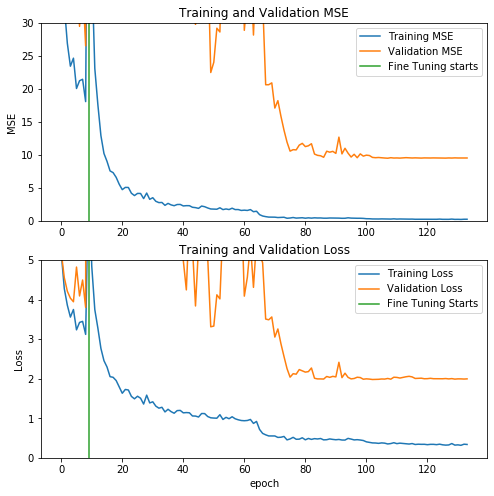

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mse, label='Training MSE')
plt.plot(val_mse, label='Validation MSE')
plt.ylim([0, 30])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Fine Tuning starts')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.title('Training and Validation MSE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Fine Tuning Starts')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.


In [51]:
if isGoogleColab():
    !ls -l "/content/drive/MyDrive/Healthcare/Radioterapia/data/ciolaplata/models/"

In [52]:
print(f'Best saved model file = {callbackObj.saved_model_file}')
saved_model = callbackObj.saved_model

Best saved model file = /hdd/data/radioterapia/ciolaplata/models/1612658501.mobilenetV2.23456.h5


In [53]:
# Evaluate the saved model on the train set which differs from values reported during training
loss, mse = saved_model.evaluate(tmp_train_batches, verbose=2)
print("Saved model, train loss: {:5.4f}".format(loss))
print('Saved model, train mse: {:5.4f}\n'.format(mse))

# Evaluate the saved model on the validation set which differs from values reported during training
loss, mse = saved_model.evaluate(tmp_validation_batches, verbose=2)
print("Saved model, validation loss: {:5.4f}".format(loss))
print('Saved model, validation mse: {:5.4f}'.format(mse))

107/107 - 3s - loss: 0.2923 - mean_squared_error: 0.1616
Saved model, train loss: 0.2923
Saved model, train mse: 0.1616

27/27 - 1s - loss: 1.9808 - mean_squared_error: 9.5900
Saved model, validation loss: 1.9808
Saved model, validation mse: 9.5900


In [54]:
#result_batch = model.predict(tmp_train_batches)
#reloaded_result_batch = reloaded_model.predict(tmp_train_batches)
#print(abs(reloaded_result_batch - result_batch).max())
#np.testing.assert_allclose(result_batch, reloaded_result_batch, rtol=1e-6, atol=1e-6)

In [55]:
# projects out just the first two components.
if ARG_TEST_PARTITION:
    tmp_test_batches = test_batches.map(lambda image, gamma, filename: (image, gamma))
    print(tmp_test_batches)

    # Evaluate the reloaded model on the test set
    loss, mse = saved_model.evaluate(tmp_test_batches, verbose=1)
    print("\n\nSaved model, test loss: {:5.4f}".format(loss))
    print('Saved model, test mse: {:5.4f}'.format(mse))

In [56]:
if isGoogleColab():
    drive.flush_and_unmount()
    print('All changes made in this colab session should now be visible in Drive.')